In [27]:
# !pip install python-dotenv==1.1.0
# !pip install langgraph-checkpoint==2.0.26
# !pip install langgraph==0.4.5
# !pip install Pillow
# pip install -U langchain-tavily==0.1.6


In [28]:
# Load in the OpenAI key and Tavily key.
# In the project folder, create a file named 'config.env'
# ensure your .env file contains keys named OPENAI_API_KEY="your key" and TAVILY_API_KEY="your key"
from dotenv import load_dotenv
import os 

load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

In [29]:
import time

# Helper functions
def display_text_to_user(text):
    print(text) 
    time.sleep(1) # wait for it to render before asking for input or it'll never show up.
    
def ask_user_for_input(input_description):
    response = input(input_description)
    return response

In [37]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    topic: str
    topic_answer: str
    user_additional_information: Annotated[list, str]
    

In [31]:
import json
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.messages import ToolMessage
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0, 
    streaming=False,
    base_url = "https://openai.vocareum.com/v1",
    max_tokens=250
)

tavily_search_tool = TavilySearch(
    api_key=os.getenv('TAVILY_API_KEY'),
    max_results=2,
    topic="general",
    include_raw_content=True
    # include_answer=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)
# tavily_search_tool.invoke("apple meaning")

@tool
def user_clarification(query: str) -> str:
    user_response = interrupt({"query": query})
    return user_response["data"]

class ToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tools = [tavily_search_tool, user_clarification]
tool_node = ToolNode(tools=tools)
model_with_tools = model.bind_tools(tools=tools)

In [32]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END

def get_topic_from_user(state: State):
    topic = ask_user_for_input(
        "What helth topic or medical condition you'd like to learn about today?")
    human_message = HumanMessage(content=f"Tell me everything I need to know about {topic}. Summarize the results in 3-5 sentences in patient-friendly language.")
    return {"topic": topic, "messages": [human_message]}

def clarify_user_request(state: State):
    topic = state['topic']
    
    prompt = f"""Patient want to learn about this topic: {topic}. Do you have any question for the user before answering them?
    Response format: JSON
    Example format:
    {
        
    }
    """
    response = model_with_tools.invoke(prompt)
    return {"mess"}

def answer_user_question(state: State):
    messages = state.get("messages", [])

    ai_response = model_with_tools.invoke(messages)
    messages.append(ai_response)

    return {'topic_answer': ai_response, 'messages': messages}


def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(
            f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [33]:
from langgraph.checkpoint.memory import MemorySaver
from PIL import Image

workflow = StateGraph(State)

workflow.add_node("tools", tool_node)
workflow.add_node("get_topic_from_user", get_topic_from_user)
workflow.add_node("answer_user_question", answer_user_question)

workflow.add_edge(START, "get_topic_from_user")
workflow.add_edge("get_topic_from_user", "answer_user_question")
workflow.add_conditional_edges(
    "answer_user_question",
    route_tools,
    {
        "tools": "tools",
        END: END,
    })
workflow.add_edge("tools", "answer_user_question")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

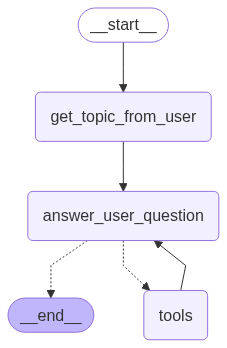

In [34]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [35]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "2"})  
# app.invoke({"topic": "", "messages": []}, config=config)

In [36]:
def stream_graph_updates(user_input: str):
    for event in app.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        stream_graph_updates(user_input)
        user_input = input("Do you want to continue? ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Tell me everything I need to know about sick. Summarize the results in 3-5 sentences in patient-friendly language.

Assistant: 
Assistant: {"query": "sick", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.dictionary.com/browse/sick", "title": "SICK Definition & Meaning - Dictionary.com", "content": "adjective. sicker, sickest. affected with ill health, disease, or illness; ailing: She was sick with the flu for two weeks. Synonyms: indisposed, infirm.", "score": 0.7742597, "raw_content": null}, {"url": "https://dictionary.cambridge.org/us/dictionary/english/sick", "title": "SICK | definition in the Cambridge English Dictionary", "content": "physically or mentally ill; not well or healthy: a sick child, a sick cow. My father has been off sick (= not working because of illness) for a long time.", "score": 0.76596165, "raw_content": null}], "response_time": 3.48}
The term "sick" refers to being physically or mentally unwell. It can des